# Project 2

### Author : Omer Ozeren

## Introduction 

In this assignment, we are asked to 

1- Identify a large 2-node network dataset—you can start with a dataset in a repository.  Your data should meet the criteria that it consists of ties between and not within two (or more) distinct groups.

2- Reduce the size of the network using a method such as the island method described in chapter 4 of social network analysis.

3-What can you infer about each of the distinct groups?

**I chose to use a dataset which includes Scientific collaborations.Please click [here](https://toreopsahl.com/datasets/) to review futher information about dataset.**

### Load Libraries

In [3]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import math
from networkx.algorithms import bipartite as bi
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

### Reading in the data

In [4]:
raw_data = pd.read_csv('http://opsahl.co.uk/tnet/datasets/Newman-Cond_mat_95-99-co_occurrence.txt', 
                       delim_whitespace=True, 
                       header=None, 
                       names=['author', 'research', 'weight'])
raw_data.head()

,author,research,weight
0,1,190,7
1,1,201,3
2,1,562,2
3,1,1075,3
4,1,2281,1


### Dataset

This is a bipartite network of research and the author that have involved in reasearch.

In [5]:
G = nx.from_pandas_edgelist(raw_data,  source='author', target='research', edge_attr='weight', create_using=None)
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 16264
Number of edges: 47594
Average degree:   5.8527


#### We have 16,264 nodes with 47,594 edges

### Distribution of Research by Author

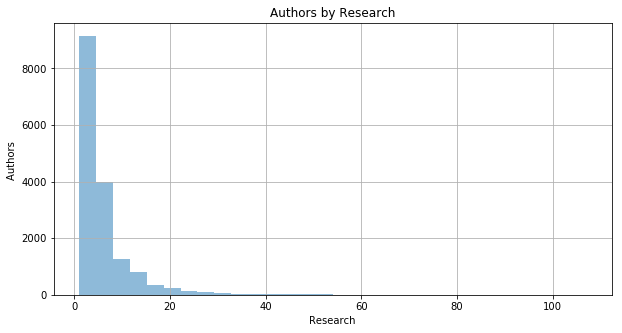

In [11]:
research_count = pd.DataFrame({'Research_Count' : raw_data.groupby(['author']).size()}).reset_index()
research_count.iloc[:,1].plot.hist(alpha = 0.5, bins = 30)
plt.title('Authors by Research')
plt.xlabel('Research')
plt.ylabel('Authors ')
plt.grid(True)
plt.rcParams['figure.figsize'] = (5, 5)

### Data Preparation

I will reduce the size of the network by island method. The island method can split up the whole network or the giant component into smaller components,which provides a simple and efficient means to investigate features of sub- networks or group behaviors.The Weights are the number of shared neighbors for an edge.**The weights in my data presents the sum of joint papers that authors are contributed.** First,I will look at the distribution of weights, Second I'll isolate the biggest and smallest component of the bipartite graph, then I'll apply the island method to put authors and thresholds in dataframe. I will reduce the size of the network based on  (weight).

#### Let's look at the distribution of the weights to find out if there is a way to split the data based on weights.

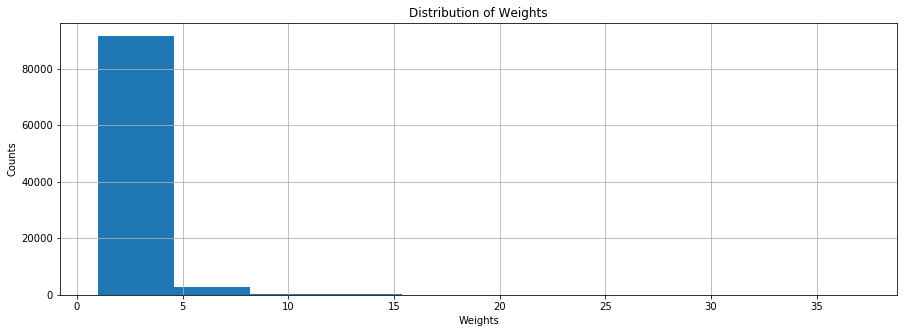

In [23]:
plt.hist(raw_data['weight'])
# Add title and axis names
plt.title('Distribution of Weights')
plt.xlabel('Weights')
plt.ylabel('Counts')
plt.grid(True)
plt.rcParams['figure.figsize'] = (15, 5)

### Trim Edges and Island Method function from the book 

Let's create function for island method and trim edges then I'll isolate the biggest and smallest component of the bipartite graph.The code 'trim_edges" and "island_method" is taken from Chapter 4 from Social Network Analysis book .**Please click [here](https://www.oreilly.com/library/view/social-network-analysis/9781449311377/ch04.html) to see the chapter 4.**

In [24]:
def trim_edges(g, weight = 1):
    edges = []
    g2 = nx.Graph()
    for f, to, edata in g.edges(data = True):
        if edata['weight'] > weight:
            x = float(edata['weight'])
            edges.append((f, to, x))
    g2.add_weighted_edges_from(edges)
    return g2

def island_method(g, iterations = 5):
    weights = [edata['weight'] for f, to, edata in g.edges(data = True)]
    mn = int(min(weights))
    mx = int(max(weights))
    step = int((mx - mn) / iterations)
    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn, mx, step)]

### Bipartite Projection

In [25]:
author_graph = bi.weighted_projected_graph(G, raw_data.author, ratio = False)
print(nx.info(author_graph))

Name: 
Type: Graph
Number of nodes: 16264
Number of edges: 319798
Average degree:  39.3259


**We have 16,264 nodes with 31,979 edges**

In [26]:
islands = island_method(author_graph)
thresholds =list()
Authors =list()
for island in islands:
    thresholds.append(island[0])
    Authors.append(len(island[1]))
_df = {'Thresholds':thresholds,'Connection between Authors':Authors}    
df = pd.DataFrame(_df)
df

,Thresholds,Connection between Authors
0,1,11685
1,17,265
2,33,27
3,49,8
4,65,4
5,81,2


### What can we infer about each of the distinct groups? 

#### Centrality

I'am going to evaluate the important nodes by calculation degree and degree of centrality.The **degree of a node** is the number of neighbors that it has. The **degree centrality** is the number of neighbors divided by all possible neighbors that it could have.

In [27]:
df_degree = pd.DataFrame.from_dict(dict(nx.degree(author_graph)), 
                                orient='index', 
                                columns=['Degree'])
df_degree_centrality = pd.DataFrame.from_dict(nx.degree_centrality(author_graph), 
                                           orient='index', 
                                           columns=['Degree_Centrality'])

dfs = [df_degree,df_degree_centrality]
combined = pd.concat(dfs, axis=1)
combined.sort_values(by=['Degree', 'Degree_Centrality'], ascending=False).head(10)

,Degree,Degree_Centrality
4034,719,0.044211
4474,694,0.042674
7315,670,0.041198
4673,615,0.037816
5489,613,0.037693
5199,608,0.037385
7314,605,0.037201
406,591,0.036340
36,590,0.036279
5196,590,0.036279


As I see from table ,within the authors that has the highest sum of contribution to researches the authors **{4034,4474,7315,4673}** has the highest degree and degree centrality.Next, I will find out these highest degree valued authors strongest relationships.

#### Degree centrality distribution

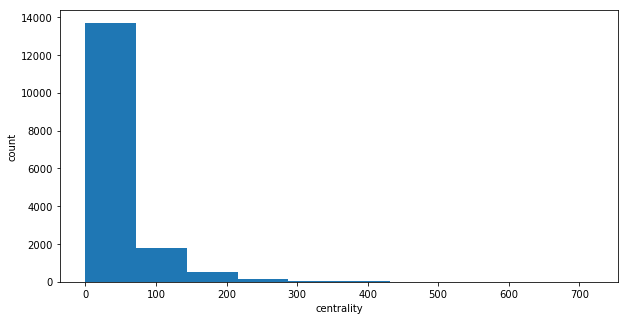

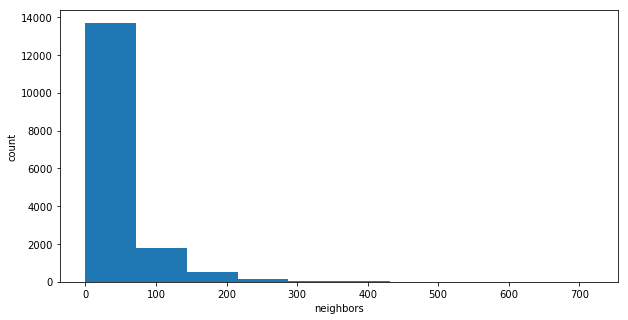

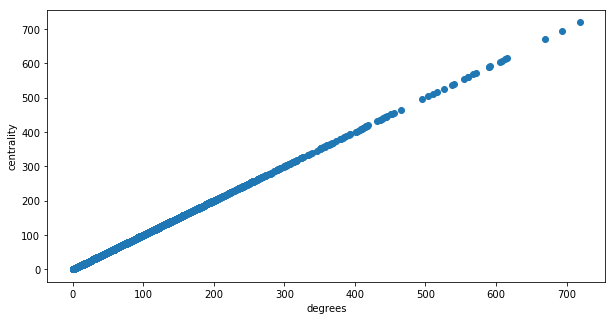

In [28]:
# Import matplotlib.pyplot
import matplotlib.pyplot as plt
 
# Compute the degree centrality of the Twitter network: deg_cent
deg_cent = dict(nx.degree(author_graph))

# Compute the degree of every node: degrees
degrees = [len(list(author_graph.neighbors(n))) for n in author_graph.nodes()]
 
# Plot a histogram of the degree centrality distribution of the graph.
plt.figure(figsize = (10, 5))
plt.hist(list(deg_cent.values()))
plt.xlabel('centrality')
plt.ylabel('count')
plt.show()
 
# Plot a histogram of the degree distribution of the graph
plt.figure(figsize = (10, 5))
plt.hist(degrees)
plt.xlabel('neighbors')
plt.ylabel('count')
plt.show()
 
# Plot a scatter plot of the centrality distribution and the degree distribution
plt.figure(figsize = (10, 5))
plt.scatter(degrees, list(deg_cent.values()))
plt.xlabel('degrees')
plt.ylabel('centrality')
plt.show()

#### Graph with Weight treshhold of 33.

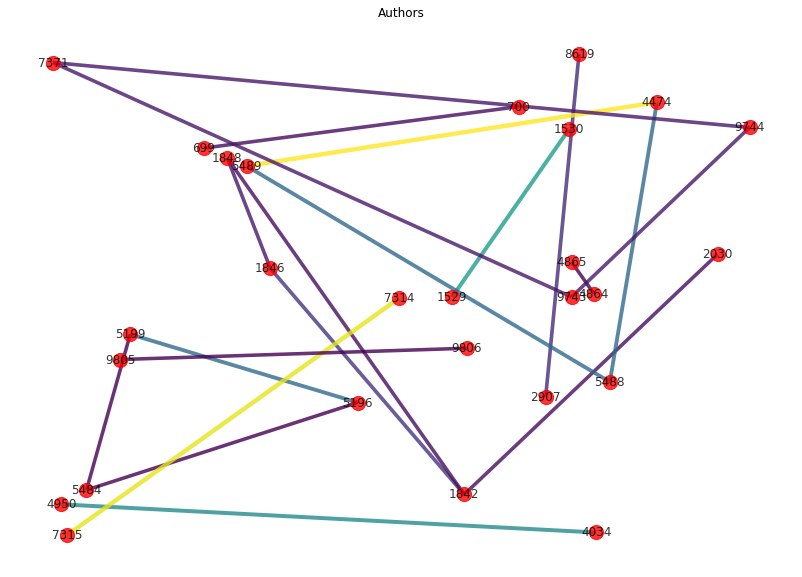

In [29]:
plt.figure(figsize = (14, 10))

# trim edges
island_plot = trim_edges(author_graph, 33)
weights = [math.log(data_['weight']) for from_, t0_, data_ in island_plot.edges(data=True)]

# draw threshold 
sp = nx.random_layout(island_plot)
nx.draw_networkx(island_plot, sp, width = weights, edge_color = weights, node_size = 200,
                node_shape = None, node_color = "Red", alpha = 0.8)
plt.axis('off')
plt.title("Authors")
plt.show()

#### Lets verify the grap abow by getting edge attributes

In [30]:
strong_relations = pd.DataFrame.from_dict(nx.get_edge_attributes(author_graph, 'weight'), orient='index', columns=['Weight']) \
.sort_values(by=['Weight'], ascending=False).head(10)
strong_relations

,Weight
"(4474, 5489)",84
"(7314, 7315)",81
"(1529, 1530)",57
"(4034, 4950)",53
"(5488, 5489)",47
"(5196, 5199)",47
"(4474, 5488)",47
"(1842, 1846)",40
"(2907, 8619)",39
"(7371, 9744)",37


The Light colors (green and yellow) indicates strong relationship between Authors.As We can see above graph,  author number **(4474, 5489), (7314, 7315)	,(1530 and 1529), (4034, 4950), (5488, 5489)** has the strongest relationship out of all authors. As we can in the above graph, not many authors have strong relationships.

### Subgraphs

Here, I'am going to analyze a subset of nodes in a network.I will take graph object that is comprised of iterable of nodes that was passes in.Please click [here](https://datascience103579984.wordpress.com/2019/09/12/26-network-analysis-in-python-part-1-from-datacamp/) for futher information.

In [36]:
from itertools import combinations

# Write a function that identifies all nodes in a triangle relationship with a given node.
def nodes_in_triangle(G, n):
    """
    Returns the nodes in a graph `G` that are involved in a triangle relationship with the node `n`.
    """
    triangle_nodes = set([n])

    # Iterate over all possible triangle relationship combinations
    for n1, n2 in combinations(G.neighbors(n), 2):

        # Check if n1 and n2 have an edge between them
        if G.has_edge(n1, n2):

            # Add n1 to triangle_nodes
            triangle_nodes.add(n1)

            # Add n2 to triangle_nodes
            triangle_nodes.add(n2)

    return triangle_nodes

In [32]:
def get_nodes_and_nbrs(G, nodes_of_interest):
    """
    Returns a subgraph of the graph `G` with only the `nodes_of_interest` and their neighbors.
    """
    nodes_to_draw = []
 
    # Iterate over the nodes of interest
    for n in nodes_of_interest:
 
        # Append the nodes of interest to nodes_to_draw
        nodes_to_draw.append(n)
 
        # Iterate over all the neighbors of node n
        for nbr in G.neighbors(n):
 
            # Append the neighbors of n to nodes_to_draw
            nodes_to_draw.append(nbr)
 
    return G.subgraph(nodes_to_draw)

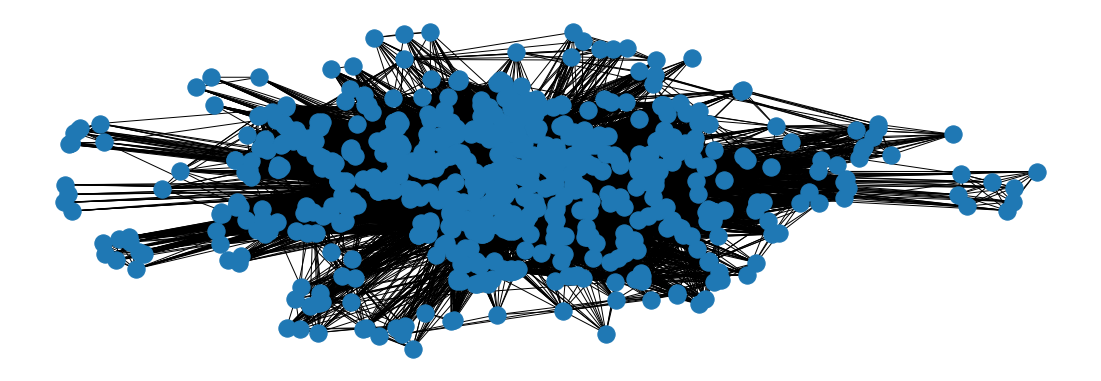

In [50]:
# Draw the subgraph to the screen
T_draw = get_nodes_and_nbrs(author_graph, [4474, 5489])
nx.draw(T_draw)
plt.show()

In [46]:
list(nodes_of_interest)[:5]

[14336, 14337, 14338, 14339, 14340]